# Hybrid quantum-classical Neural Networks with PyTorch and Qiskit

Machine learning (ML) has established itself as a successful interdisciplinary field which seeks to mathematically extract generalizable information from data. Throwing in quantum computing gives rise to interesting areas of research which seek to leverage the principles of quantum mechanics to augment machine learning or vice-versa. Whether you're aiming to enhance classical ML algorithms by outsourcing difficult calculations to a quantum computer or optimise quantum algorithms using classical ML architectures - both fall under the diverse umbrella of quantum machine learning (QML).

We are going try aplly the algorithm to another trained model, CIFAR1O, and try to train the model to know the difference beetwhen birds and airplanes.


##  Let's code! <a id='code'></a>


### Imports <a id='imports'></a>
First, we import some handy packages that we will need, including Qiskit and PyTorch.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

### Create a "Quantum Class" with Qiskit <a id='q-class'></a>
We can conveniently put our Qiskit quantum functions into a class. First, we specify how many trainable quantum parameters and how many shots we wish to use in our quantum circuit. In this example, we will keep it simple and use a 1-qubit circuit with one trainable quantum parameter $\theta$. We hard code the circuit for simplicity and use a $RY-$rotation by the angle $\theta$ to train the output of our circuit. The circuit looks like this:

<img src="1qubitcirc.png" width="400"/>

In order to measure the output in the $z-$basis, we calculate the $\sigma_\mathbf{z}$ expectation. 
$$\sigma_\mathbf{z} = \sum_i z_i p(z_i)$$
We will see later how this all ties into the hybrid neural network.

In [ ]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])


Let's test the implementation

In [ ]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

### Create a "Quantum-Classical Class" with PyTorch <a id='qc-class'></a>
Now that our quantum circuit is defined, we can create the functions needed for backpropagation using PyTorch. [The forward and backward passes](http://www.ai.mit.edu/courses/6.034b/backprops.pdf) contain elements from our Qiskit class. The backward pass directly computes the analytical gradients using the finite difference formula we introduced above.

In [ ]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

### Data Loading and Preprocessing <a id='data-loading-preprocessing'></a>
##### Putting this all together:
We will create a simple hybrid neural network to classify images of two types of digits (0 or 1) from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). We first load MNIST and filter for pictures containing 0's and 1's. These will serve as inputs for our neural network to classify.

Let's make an initial exploration on our data and compare with the base code we already have

In [ ]:
""" first the mnist databse """

n_samples = 100

X_train_m = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train_m.targets == 0)[0][:n_samples], 
                np.where(X_train_m.targets == 1)[0][:n_samples])

X_train_m.data = X_train_m.data[idx]
X_train_m.targets = X_train_m.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train_m, batch_size=1, shuffle=True)

""" this is the base code we need to run, let´s see  """

print(X_train_m)

print(f"the type of X_train_m is: {type(X_train_m)}")

print(f"The X_train_m.data look like: {X_train_m.data}")

print(f"The type of X_train_m.data is: {type(X_train_m.data)}")

print(f"The X_train_m.targets look like: {X_train_m.targets}")

print(f"The type of X_train_m.targets is: {type(X_train_m.targets)}")

print(f"The X_train_m.data[i] look like: { X_train_m.data[0]}")

print(f"The type of X_train_m.data[i] is: {type(X_train_m.data[0])}")

print(f"The X_train_m.targets[i] look like: { X_train_m.targets[0]}")

print(f"The type of X_train_m.targets[i] is: {type(X_train_m.targets[0])}")

Now let's check how CIFAR10 look like

In [85]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.CIFAR10(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor(),transforms.functional.rgb_to_grayscale]))

print(X_train)

print(f"the type of X_train is: {type(X_train)}")

print(f" The X_train.targets look like: \n {X_train.targets}")

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               <function rgb_to_grayscale at 0x7fc719b2b550>
           )
the type of X_train is: <class 'torchvision.datasets.cifar.CIFAR10'>
 The X_train.targets look like: 
 [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9

We notice that in CIFAR10 is only a simple vector, and on MNIST is a tensor, we need to convert it!

In [86]:
X_train.targets = torch.tensor(X_train.targets)

print(f"Now X_train.targets look like: \n {X_train.targets}")

print(f"The type now is: {type(X_train.targets)}")

print(f"Now the X_train_m.targets[i] look like: { X_train_m.targets[0]}")

print(f"Now the type of X_train_m.targets[i] is: {type(X_train_m.targets[0])}")

Now X_train.targets look like: 
 tensor([6, 9, 9,  ..., 9, 1, 1])
The type now is: <class 'torch.Tensor'>
Now the X_train_m.targets[i] look like: 0
Now the type of X_train_m.targets[i] is: <class 'torch.Tensor'>


X_train.targets fixed!!! Now let´s check X_train.data

In [87]:
print(f"The X_train_m.data look like: {X_train_m.data}")

print(f"The type of X_train_m.data is: {type(X_train_m.data)}")

print(f"The X_train_m.data[i] look like: { X_train_m.data[0]}")

print(f"The type of X_train_m.data[i] is: {type(X_train_m.data[0])}")

The X_train_m.data look like: tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0

X_train_m.data is already ok !!! That's great, now we are going to try filtering the informations

In [88]:
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 2)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [89]:
print(idx)

[  29   30   35   49   77   93  115  116  129  165  179  185  189  199
  213  220  223  233  264  276  279  284  293  308  317  332  341  344
  348  349  352  371  373  376  392  401  404  405  407  415  417  436
  439  448  453  455  457  467  468  481  497  504  527  555  557  564
  598  600  604  605  608  614  626  628  637  650  658  663  687  694
  695  698  700  708  713  731  733  735  748  752  757  765  782  783
  799  812  822  843  866  871  872  902  905  906  911  927  938  940
  965  974    6   13   18   24   41   42   47   48   54   55   57   63
   90  108  120  121  123  138  144  171  194  196  218  271  281  283
  288  300  303  335  356  358  383  400  402  403  411  421  423  425
  463  474  483  502  510  513  522  533  538  539  540  544  558  559
  560  586  630  646  648  649  673  689  696  701  709  724  737  742
  775  778  779  787  790  796  800  802  803  804  808  810  820  827
  829  830  832  849  864  885  889  907  910  912  924  933  957  963
  975 

idx is no longer a empty vector !!! So our tranformation to tensor worked 

#### Training data

torch.Size([1, 32, 32])


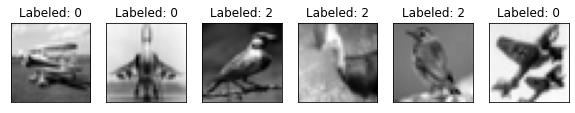

In [97]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze().transpose(1,2,0), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1
print(images[0].shape)

#### Testing data

In [92]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 2)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

So far, we have loaded the data and coded a class that creates our quantum circuit which contains 1 trainable parameter. This quantum parameter will be inserted into a classical neural network along with the other classical parameters to form the hybrid neural network. We also created backward and forward pass functions that allow us to do backpropagation and optimise our neural network. Lastly, we need to specify our neural network architecture such that we can begin to train our parameters using optimisation techniques provided by PyTorch. 


### Creating the Hybrid Neural Network <a id='hybrid-nn'></a>
We can use a neat PyTorch pipeline to create a neural network architecture. The network will need to be compatible in terms of its dimensionality when we insert the quantum layer (i.e. our quantum circuit). Since our quantum  in this example contains 1 parameter, we must ensure the network condenses neurons down to size 1. We create a typical Convolutional Neural Network with two fully-connected layers at the end. The value of the last neuron of the fully-connected layer is fed as the parameter $\theta$ into our quantum circuit. The circuit measurement then serves as the final prediction for 0 or 1 as provided by a $\sigma_z$ measurement.

In [98]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5)
        self.conv2 = nn.Conv2d(4, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

###Training the Network <a id='training'></a>
We now have all the ingredients to train our hybrid network! We can specify any [PyTorch optimiser](https://pytorch.org/docs/stable/optim.html), [learning rate](https://en.wikipedia.org/wiki/Learning_rate) and [cost/loss function](https://en.wikipedia.org/wiki/Loss_function) in order to train over multiple epochs. In this instance, we use the [Adam optimiser](https://arxiv.org/abs/1412.6980), a learning rate of 0.001 and the [negative log-likelihood loss function](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html).

In [99]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)%tb
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Traceback (most recent call last):
  Input In [99] in <cell line: 9>
    output = model(data)%tb
  File /opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1110 in _call_impl
    return forward_call(*input, **kwargs)
  Input In [98] in forward
    x = F.relu(self.fc1(x))
  File /opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1110 in _call_impl
    return forward_call(*input, **kwargs)
  File /opt/conda/lib/python3.8/site-packages/torch/nn/modules/linear.py:103 in forward
    return F.linear(input, self.weight, self.bias)
RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x400 and 256x64)

Use %tb to get the full traceback.


Plot the training graph

In [ ]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

### Testing the Network <a id='testing'></a>

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

In [ ]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1